# Tax Calibration

In [82]:
# Import packages and load the data
import numpy as np
import numpy.linalg as lin
import scipy.stats as sts
import scipy.integrate as intgr
import scipy.optimize as opt
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
from mpl_toolkits.mplot3d import Axes3D
# This next command is specifically for Jupyter Notebook
%matplotlib notebook

import requests
from IPython.display import Image

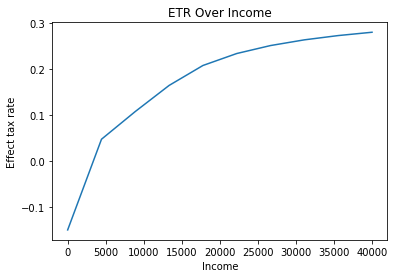

In [160]:
### Effective Tax Function
#Source: https://www.jetro.go.jp/en/invest/setting_up/section3/page7.html
def calc_income_tax(income_x, income_y, year):
    total_income = income_x + income_y
    deducted_x = income_x - find_tax_deduction(income_x, year)
    taxable_income = deducted_x + income_y
    tax_cost = find_tax_cost(taxable_income)
    effective_tax_rate = tax_cost / total_income
    if 2013 <= year <= 2037:
        #Withholding Tax
        effective_tax_rate *= 1.021
    return max(effective_tax_rate, -0.15)
    

def find_tax_cost(income):
    if income <= 1950:
        return income * 0.05
    elif 1950 < income <= 3300:
        return (income - 1950) * 0.1 + find_tax_cost(1950)
    elif 3300 < income <= 6950:
        return (income - 3300) * 0.2 + find_tax_cost(3300)
    elif 6950 < income <= 9000:
        return (income - 6950) * 0.23 + find_tax_cost(6950)
    elif 9000 < income <= 18000:
        return (income - 9000) * 0.33 + find_tax_cost(9000)
    elif 18000 < income <= 40000:
        return (income - 18000) * 0.33 + find_tax_cost(18000)
    elif 40000 < income:
        return (income - 40000) * 0.33 + find_tax_cost(40000)
    
def find_tax_deduction(income, year):
    if year < 2020:
        if income <= 1625:
            return 650000
        elif 1625 < income <= 1800:
            return income * 0.4
        elif 1800 < income <= 3600:
            return income * 0.3 + 180
        elif 3600 < income <= 6600:
            return income * 0.2 + 540
        elif 6600 < income <= 10000:
            return income * 0.1 + 1200
        elif 10000 < income:
            return 2200
    else:
        if income <= 1625:
            return 550
        elif 1625 < income <= 1800:
            return income * 0.4 - 100
        elif 1800 < income <= 3600:
            return income * 0.3 + 80
        elif 3600 < income <= 6600:
            return income * 0.2 + 440
        elif 6600 < income <= 10000:
            return income * 0.1 + 1100
        elif 10000 < income:
            return 1950

calc_income_tax(5000, 0, 2015)
#%%
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
incomes = np.linspace(1, 40000, 10)
vals = pd.Series(incomes).apply(calc_income_tax, args=[0, 2015])
plt.plot(incomes, vals)
plt.xlabel("Income")
plt.ylabel("Effect tax rate")
plt.title("ETR Over Income")
plt.show()
        

In [131]:
def tax_func(I, phi0, phi1, phi2):
    # URL: https://www.jstor.org/stable/pdf/41789070.pdf
    #txrates = ((phi0 * (I - ((I ** -phi1) + phi2) ** (-1 / phi1))) / I)
    txrates = phi0 - phi0 * (phi1 * I ** phi2 + 1)**(-1 / phi2)
    return txrates

In [156]:
def model_moments(I_array, phi0, phi1, phi2):
    
    return tax_func(I_array, phi0, phi1, phi2)

In [157]:
def data_moments(I_array):
    dms = []
    for i in I_array:
        dms.append(calc_income_tax(i, 0, 2018))
    return np.array(dms)

In [158]:
def err_vec(I_array, phi0, phi1, phi2, simple):
    
    data_mms = data_moments(I_array)
    model_mms = model_moments(I_array, phi0, phi1, phi2)
    
    if simple:
        err_vec = model_mms - data_mms
    else:
        err_vec = (model_mms - data_mms) / data_mms
    
    return err_vec

In [163]:
I

array([ 1.        ,  1.48717949,  1.97435897,  2.46153846,  2.94871795,
        3.43589744,  3.92307692,  4.41025641,  4.8974359 ,  5.38461538,
        5.87179487,  6.35897436,  6.84615385,  7.33333333,  7.82051282,
        8.30769231,  8.79487179,  9.28205128,  9.76923077, 10.25641026,
       10.74358974, 11.23076923, 11.71794872, 12.20512821, 12.69230769,
       13.17948718, 13.66666667, 14.15384615, 14.64102564, 15.12820513,
       15.61538462, 16.1025641 , 16.58974359, 17.07692308, 17.56410256,
       18.05128205, 18.53846154, 19.02564103, 19.51282051, 20.        ])

In [164]:
I_array

array([1.00000000e+00, 1.38027586e+03, 2.75955172e+03, 4.13882759e+03,
       5.51810345e+03, 6.89737931e+03, 8.27665517e+03, 9.65593103e+03,
       1.10352069e+04, 1.24144828e+04, 1.37937586e+04, 1.51730345e+04,
       1.65523103e+04, 1.79315862e+04, 1.93108621e+04, 2.06901379e+04,
       2.20694138e+04, 2.34486897e+04, 2.48279655e+04, 2.62072414e+04,
       2.75865172e+04, 2.89657931e+04, 3.03450690e+04, 3.17243448e+04,
       3.31036207e+04, 3.44828966e+04, 3.58621724e+04, 3.72414483e+04,
       3.86207241e+04, 4.00000000e+04])

In [162]:
tax_func(I, phi0, phi1, phi2)

array([0.01259015, 0.01725403, 0.02156438, 0.02561451, 0.02945828,
       0.03313081, 0.03665683, 0.04005475, 0.04333878, 0.04652029,
       0.04960853, 0.05261124, 0.05553495, 0.05838527, 0.06116707,
       0.06388464, 0.06654174, 0.06914174, 0.07168768, 0.07418227,
       0.076628  , 0.07902712, 0.08138171, 0.08369366, 0.08596473,
       0.08819656, 0.09039064, 0.09254839, 0.09467112, 0.09676006,
       0.09881636, 0.10084111, 0.10283534, 0.1048    , 0.10673601,
       0.10864423, 0.11052547, 0.11238053, 0.11421013, 0.11601497])

In [161]:

data_mms = data_moments(I_array)
model_mms = model_moments(I_array, phi0, phi1, phi2)
print(I_array)
print(data_mms)
print(model_mms)

[1.00000000e+00 1.38027586e+03 2.75955172e+03 4.13882759e+03
 5.51810345e+03 6.89737931e+03 8.27665517e+03 9.65593103e+03
 1.10352069e+04 1.24144828e+04 1.37937586e+04 1.51730345e+04
 1.65523103e+04 1.79315862e+04 1.93108621e+04 2.06901379e+04
 2.20694138e+04 2.34486897e+04 2.48279655e+04 2.62072414e+04
 2.75865172e+04 2.89657931e+04 3.03450690e+04 3.17243448e+04
 3.31036207e+04 3.44828966e+04 3.58621724e+04 3.72414483e+04
 3.86207241e+04 4.00000000e+04]
[-0.15       -0.15        0.03240511  0.04430674  0.06427786  0.08497182
  0.10143786  0.11491383  0.12916982  0.15089712  0.16949906  0.18471905
  0.19740253  0.20813481  0.21733399  0.22530667  0.23228282  0.23843827
  0.24390981  0.24880543  0.25321149  0.25719795  0.26082202  0.26413096
  0.26716416  0.26995471  0.27253061  0.27491571  0.27713045  0.27919245]
[0.01259015 0.44684475 0.46192799 0.4673542  0.47015644 0.47186919
 0.47302499 0.47385776 0.47448644 0.47497791 0.47537272 0.47569685
 0.47596773 0.47619749 0.47639486 0.47656

In [146]:
def criterion(params, *args):
    
    phi0, phi1, phi2 = params
    I_array, W = args
    
    err = err_vec(I_array, phi0, phi1, phi2, simple = False)
    crit_val = err.T @ W @ err
    return crit_val

In [153]:
# Initial guess of parameters
phi0 = 0.479
phi1 = 0.022
phi2 = 0.817
params_init = np.array([phi0, phi1, phi2])

# Weighting matrix 
W_hat = np.eye(30)

# Arguments
I_array = np.linspace(1, 40000, 30)
gmm_args = (I_array, W_hat)

# Optimization
results_GMM = opt.minimize(criterion, params_init, args = (gmm_args), method = 'L-BFGS-B')

print(results_GMM)
phi0_GMM, phi1_GMM, phi2_GMM = results_GMM.x

      fun: nan
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>
      jac: array([16.45675454,  5.91334586,  0.54864677])
  message: b'ABNORMAL_TERMINATION_IN_LNSRCH'
     nfev: 84
      nit: 0
   status: 2
  success: False
        x: array([0.479, 0.022, 0.817])


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in double_scalars
  after removing the cwd from sys.path.


In [141]:
I_array

array([ 1000.        ,  1473.68421053,  1947.36842105,  2421.05263158,
        2894.73684211,  3368.42105263,  3842.10526316,  4315.78947368,
        4789.47368421,  5263.15789474,  5736.84210526,  6210.52631579,
        6684.21052632,  7157.89473684,  7631.57894737,  8105.26315789,
        8578.94736842,  9052.63157895,  9526.31578947, 10000.        ])

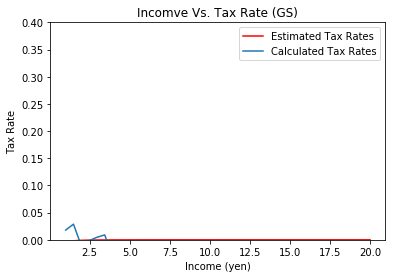

In [128]:
import matplotlib.pyplot as plt 
%matplotlib inline
I = np.linspace(1,20,40)

tax_rate = tax_func(I, phi0_GMM, phi1_GMM, phi3_GMM)
plt.xlabel('Income (yen)')
plt.ylim(0, 0.4)
plt.ylabel('Tax Rate')
plt.title('Incomve Vs. Tax Rate (GS)')
plt.plot(I, tax_rate, color = 'r', label = r'Estimated Tax Rates')
plt.legend(loc='upper right')


tax_rate_data = []
for i in I:
    tax_rate_data.append(calc_income_tax(i, 0, 2018))
tax_rate_data = np.array(tax_rate_data)
plt.plot(I, tax_rate_data, label = r'Calculated Tax Rates')
plt.legend(loc='upper right')

plt.show()

In [127]:
I

array([ 1000000.        ,  1487179.48717949,  1974358.97435897,
        2461538.46153846,  2948717.94871795,  3435897.43589744,
        3923076.92307692,  4410256.41025641,  4897435.8974359 ,
        5384615.38461538,  5871794.87179487,  6358974.35897436,
        6846153.84615385,  7333333.33333333,  7820512.82051282,
        8307692.30769231,  8794871.7948718 ,  9282051.28205128,
        9769230.76923077, 10256410.25641026, 10743589.74358974,
       11230769.23076923, 11717948.71794872, 12205128.2051282 ,
       12692307.69230769, 13179487.17948718, 13666666.66666667,
       14153846.15384615, 14641025.64102564, 15128205.12820513,
       15615384.61538461, 16102564.1025641 , 16589743.58974359,
       17076923.07692308, 17564102.56410256, 18051282.05128205,
       18538461.53846154, 19025641.02564102, 19512820.51282051,
       20000000.        ])

In [107]:
tax_rate = tax_func(I, phi0_GMM, phi1_GMM, phi2_GMM)
tax_rate

array([-9.36750677e-15, -3.70536934e-15, -1.91513472e-15, -1.13797860e-15,
       -7.49400542e-16, -5.27355937e-16, -3.88578059e-16, -2.91433544e-16,
       -2.35922393e-16, -1.80411242e-16, -1.52655666e-16, -1.24900090e-16,
       -1.11022302e-16, -9.71445147e-17, -6.93889390e-17, -6.93889390e-17,
       -5.55111512e-17, -5.55111512e-17, -5.55111512e-17, -4.16333634e-17,
       -2.77555756e-17, -2.77555756e-17, -2.77555756e-17, -2.77555756e-17,
       -2.77555756e-17, -2.77555756e-17, -2.77555756e-17, -1.38777878e-17,
       -1.38777878e-17, -1.38777878e-17, -1.38777878e-17, -1.38777878e-17,
       -1.38777878e-17, -1.38777878e-17, -1.38777878e-17, -1.38777878e-17,
       -1.38777878e-17, -1.38777878e-17, -1.38777878e-17, -1.38777878e-17])

In [94]:
tax_rate_data = []
for i in I:
    tax_rate_data.append(calc_income_tax(i, 0, 2018))
tax_rate_data = np.array(tax_rate_data)
tax_rate_data

array([0.0178675 , 0.02873763, 0.03108083, 0.03200197, 0.03261873,
       0.0371484 , 0.04225138, 0.04660687, 0.05172087, 0.06182155,
       0.07024614, 0.07737986, 0.0842325 , 0.0908458 , 0.09663514,
       0.10174549, 0.10628967, 0.11102952, 0.11603223, 0.12114675,
       0.12630184, 0.13128941, 0.13983902, 0.1477061 , 0.15496924,
       0.16169541, 0.16794205, 0.17375866, 0.17918818, 0.184268  ,
       0.18903086, 0.19350551, 0.19771736, 0.20168889, 0.20544011,
       0.20898884, 0.21235105, 0.21554108, 0.21857182, 0.2214549 ])

In [95]:
I

array([ 1000000.        ,  1487179.48717949,  1974358.97435897,
        2461538.46153846,  2948717.94871795,  3435897.43589744,
        3923076.92307692,  4410256.41025641,  4897435.8974359 ,
        5384615.38461538,  5871794.87179487,  6358974.35897436,
        6846153.84615385,  7333333.33333333,  7820512.82051282,
        8307692.30769231,  8794871.7948718 ,  9282051.28205128,
        9769230.76923077, 10256410.25641026, 10743589.74358974,
       11230769.23076923, 11717948.71794872, 12205128.2051282 ,
       12692307.69230769, 13179487.17948718, 13666666.66666667,
       14153846.15384615, 14641025.64102564, 15128205.12820513,
       15615384.61538461, 16102564.1025641 , 16589743.58974359,
       17076923.07692308, 17564102.56410256, 18051282.05128205,
       18538461.53846154, 19025641.02564102, 19512820.51282051,
       20000000.        ])

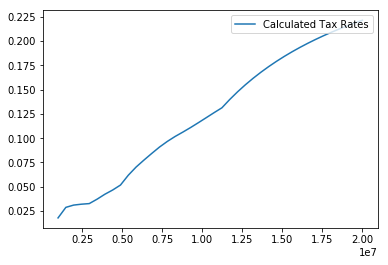

In [101]:
tax_rate_data = []
for i in I:
    tax_rate_data.append(calc_income_tax(i, 0, 2018))
tax_rate_data = np.array(tax_rate_data)
plt.plot(I, tax_rate_data, label = r'Calculated Tax Rates')
plt.legend(loc='upper right')

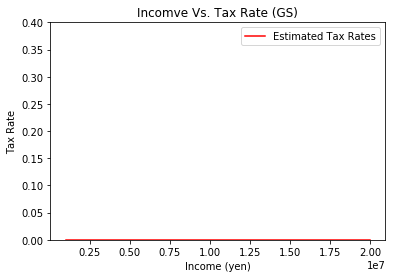

In [102]:
tax_rate = tax_func(I, phi0_GMM, phi1_GMM, phi3_GMM)
plt.xlabel('Income (yen)')
plt.ylim(0, 0.4)
plt.ylabel('Tax Rate')
plt.title('Incomve Vs. Tax Rate (GS)')
plt.plot(I, tax_rate, color = 'r', label = r'Estimated Tax Rates')
plt.legend(loc='upper right')

In [103]:
tax_rate

array([-9.36750677e-15, -3.70536934e-15, -1.91513472e-15, -1.13797860e-15,
       -7.49400542e-16, -5.27355937e-16, -3.88578059e-16, -2.91433544e-16,
       -2.35922393e-16, -1.80411242e-16, -1.52655666e-16, -1.24900090e-16,
       -1.11022302e-16, -9.71445147e-17, -6.93889390e-17, -6.93889390e-17,
       -5.55111512e-17, -5.55111512e-17, -5.55111512e-17, -4.16333634e-17,
       -2.77555756e-17, -2.77555756e-17, -2.77555756e-17, -2.77555756e-17,
       -2.77555756e-17, -2.77555756e-17, -2.77555756e-17, -1.38777878e-17,
       -1.38777878e-17, -1.38777878e-17, -1.38777878e-17, -1.38777878e-17,
       -1.38777878e-17, -1.38777878e-17, -1.38777878e-17, -1.38777878e-17,
       -1.38777878e-17, -1.38777878e-17, -1.38777878e-17, -1.38777878e-17])

In [90]:
def chi_n_func(s, a0, a1, a2, a3, a4):
    chi_n = a0 + a1*s + a2*s**2 + a3*s**3 + a4 * s**4
    return chi_n

In [91]:
s = np.array([1,2,3])
chi_n_func(s, 1,2,3,4, 5)

array([ 15, 129, 547])